# Introduction to TuLiPa

This demo will go through a minimal model with TuLiPa, to give an overview over how TuLiPa is used to solve linear programming problems in the energy market. The rest of the notebook explains the data elements and modelojbects used for this model. For more information about TuLiPa look at https://github.com/NVE/TuLiPa#readme. To get a deeper look into more features and realistic use cases with TuLiPa, look into demo 1-9 notebooks. This demo will focus on:

* Loading data, building a simple model, solving and plotting results to get an overview.
* More details about the data elements involved in creating this model
   - Time concepts
   - Power balance and demand
   - Cost
   - Upper bound capacity


## Run TuLiPa with a simple model

The minimal model contains:
- The price area GER (€/GWh)
- Inelastic demand in GER
- Three thermal plants in GER (coal, biogas and nuclear)
- The commodity power (GWh and MW)
- One horizon for the market balance (power commodity): 10 days problem length with daily resolution
- Different input data for different scenarios: Constants or time-series data for different weather scenarios and model years.

The problem will balance demand and supply in each of the 10 periods. It will cover the inelastic demand by minimizing the cost of running the power plants. 

### Import packages

In [1]:
using TuLiPa, Dates, DataFrames, CSV, JSON, Plots, JuMP, HiGHS

### Getting data and create the model

The data elements for a minimal model is loaded and settings is added. Then getmodelobjects() builds the 4 modelobjects with all their details (e.g. horizons, costs, capacities):
- The powerbalance for GER (also includes the inelastic demand)
- The three thermal plants GenBioGER, GenCoalGER and GenNucGER

In [2]:
# ---------- Load data elements for the minimal model -------
include("../test/small_model.jl")
data = get_dummy_data()
elements = data["all_elements"]

# ---------- Add settings -------------------
# The horizon for the problem is a SequentialHorizon. 
# This type consist of a number of time periods and the length of each period. 
# Here the full horizon is 10 days with a daily resolution.
power_horizon = SequentialHorizon(10, Day(1))

# Create the Commodity Power, which is the commodity of the German power balance.
# It has power_horizon as its time resolution.
push!(elements, getelement(COMMODITY_CONCEPT, "BaseCommodity", "Power", 
    (HORIZON_CONCEPT, power_horizon)))

# Select the weather scenarios 1981-1982 (some of the profiles are 1981-2010, 
# we only want to include two years of data in the model).
addscenariotimeperiod!(elements, "ScenarioTimePeriod", 
    getisoyearstart(1981), 
    getisoyearstart(1983));

# --------- Build model objects from the dataelements ----------------
modelobjects = getmodelobjects(elements)

Dict{Any, Any} with 4 entries:
  Id("Flow", "GenBioGER")           => BaseFlow(Id("Flow", "GenBioGER"), Sequen…
  Id("Flow", "GenCoalGER")          => BaseFlow(Id("Flow", "GenCoalGER"), Seque…
  Id("Flow", "GenNucGER")           => BaseFlow(Id("Flow", "GenNucGER"), Sequen…
  Id("Balance", "PowerBalance_GER") => BaseBalance(Id("Balance", "PowerBalance_…

### Build and solve the model

To build and solve the model we need the modelobjects, a problem type and a starting time.

* **TwoTime:** Indicates the starting point of the horizon. Together with the horizon it decides which data should be fetched from the time series inputs when the problem is built. The timeseriesdata of the dataset has two dimension. Information like the installed capacity of a power plant is stored related to datatime, while information like scenarios for demand, wind and solar is related to scenariotime. In this case we start with the installed capacity in 2023 and the weather scenario 1981.

* **JuMP_Prob:** This problem type uses the JuMP modelling framework (https://jump.dev/JuMP.jl/stable/) to make a Linear Programming (LP) minimization problem. The problem formulation is defined by a list of model objects and a mathematical solver. TuLiPa also has other problem types that connects directly to solvers (see HiGHS_Prob (open-source) and CPLEX_Prob) and avoids the overhead of JuMP.

* **update!():** This function will loop through all model objects and update the problem given the starting time. It will set parameters and coefficients that depend on the problem time and period in the horizon. The generic function update! has different methods depending on the inputed object. Some objects will again call update! on its internal traits.
*Update also makes it easy update the problem and solve it multiple times*

* **solve!():** Will solve the problem.

In [3]:
datatime = getisoyearstart(2023)
scenariotime = getisoyearstart(1981)
prob_time = TwoTime(datatime, scenariotime)

TwoTime(DateTime("2023-01-02T00:00:00"), DateTime("1980-12-29T00:00:00"))

In [4]:
mymodel = JuMP.Model(HiGHS.Optimizer) # we use the HiGHS solver with JuMP
prob = JuMP_Prob(modelobjects, mymodel)
update!(prob, prob_time)
solve!(prob)

We display the JuMP model

In [5]:
prob.model

A JuMP Model
Minimization problem with:
Variables: 30
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 10 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 30 constraints
`VariableRef`-in-`MathOptInterface.LessThan{Float64}`: 30 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: HiGHS
Names registered in the model: BalancePowerBalance_GER, FlowGenBioGER, FlowGenCoalGER, FlowGenNucGER

### Variables

The JuMP model above has 30 variables: 3x10 = one for each production unit (3) and horizon period (10). We display the the GenCoalGER variables.

In [6]:
prob.model[:FlowGenCoalGER]

10-element Vector{VariableRef}:
 FlowGenCoalGER[1]
 FlowGenCoalGER[2]
 FlowGenCoalGER[3]
 FlowGenCoalGER[4]
 FlowGenCoalGER[5]
 FlowGenCoalGER[6]
 FlowGenCoalGER[7]
 FlowGenCoalGER[8]
 FlowGenCoalGER[9]
 FlowGenCoalGER[10]

### Objective function

The objective function is a minimization problem that can be looked at using objective_function(). The expression will have 30 elements, 3x10 = one for each production unit (3) and for each horizon period (10). The coefficients before each variable is the cost of using that power source at the given time.

In [7]:
objective_function(prob.model)

50000 FlowGenBioGER[1] + 50000 FlowGenBioGER[2] + 50000 FlowGenBioGER[3] + 50000 FlowGenBioGER[4] + 50000 FlowGenBioGER[5] + 50000 FlowGenBioGER[6] + 50000 FlowGenBioGER[7] + 50000 FlowGenBioGER[8] + 50000 FlowGenBioGER[9] + 50000 FlowGenBioGER[10] + 124000 FlowGenCoalGER[1] + 124000 FlowGenCoalGER[2] + 124000 FlowGenCoalGER[3] + 124000 FlowGenCoalGER[4] + 124000 FlowGenCoalGER[5] + 124000 FlowGenCoalGER[6] + 124000 FlowGenCoalGER[7] + 124000 FlowGenCoalGER[8] + 124000 FlowGenCoalGER[9] + 124000 FlowGenCoalGER[10] + 5000 FlowGenNucGER[1] + 5000 FlowGenNucGER[2] + 5000 FlowGenNucGER[3] + 5000 FlowGenNucGER[4] + 5000 FlowGenNucGER[5] + 5000 FlowGenNucGER[6] + 5000 FlowGenNucGER[7] + 5000 FlowGenNucGER[8] + 5000 FlowGenNucGER[9] + 5000 FlowGenNucGER[10]

### Constraints

It is also possible to look into the constraints by inspecting the power balance, one constraint for each day. Demand values are the right hand side of the equation. Note: there are other constraints as well with upper and lower bound for the variables, e.g. the maximum and minimum a power plant can generate.

In [8]:
prob.model[:BalancePowerBalance_GER]

10-element Vector{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.EqualTo{Float64}}, ScalarShape}}:
 BalancePowerBalance_GER[1] : -FlowGenBioGER[1] - FlowGenCoalGER[1] - FlowGenNucGER[1] == -1228.595
 BalancePowerBalance_GER[2] : -FlowGenBioGER[2] - FlowGenCoalGER[2] - FlowGenNucGER[2] == -1266.7245
 BalancePowerBalance_GER[3] : -FlowGenBioGER[3] - FlowGenCoalGER[3] - FlowGenNucGER[3] == -1306.525
 BalancePowerBalance_GER[4] : -FlowGenBioGER[4] - FlowGenCoalGER[4] - FlowGenNucGER[4] == -1339.7995
 BalancePowerBalance_GER[5] : -FlowGenBioGER[5] - FlowGenCoalGER[5] - FlowGenNucGER[5] == -1354.555
 BalancePowerBalance_GER[6] : -FlowGenBioGER[6] - FlowGenCoalGER[6] - FlowGenNucGER[6] == -1211.901
 BalancePowerBalance_GER[7] : -FlowGenBioGER[7] - FlowGenCoalGER[7] - FlowGenNucGER[7] == -1102.427
 BalancePowerBalance_GER[8] : -FlowGenBioGER[8] - FlowGenCoalGER[8] - FlowGenNucGER[8] == -1349.8755
 BalancePowerBalance_GER[9

### Results

After solving the model we find the optimal values for each variable that minimizes the total cost. The results can be plotted together with demand to show that it is generating enough power for the demand each day. Demand in stippled line, while the other power plants (green, orange and blue) are stacked.

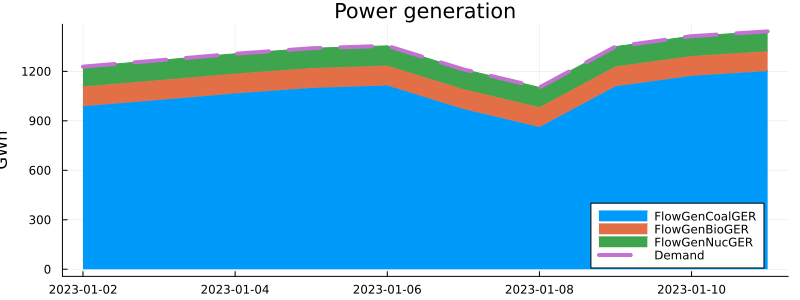

In [9]:
rhsterm = getrhsterms(modelobjects[Id("Balance", "PowerBalance_GER")])[1]

i = []
coal = []
bio = []
nuc = []
demand = []

querydelta = gettimedelta(power_horizon, 1)
for t in 1:getnumperiods(power_horizon)
    querystart = getstarttime(power_horizon, t, prob_time)
    push!(i, getdatatime(querystart))
    push!(coal, value(prob.model[:FlowGenCoalGER][t]))
    push!(bio, value(prob.model[:FlowGenBioGER][t]))
    push!(nuc, value(prob.model[:FlowGenNucGER][t]))
    push!(demand, getparamvalue(rhsterm, querystart, querydelta))
end

p = plot(areaplot(i, 
        hcat([coal, bio, nuc]...),
        title="Power generation", 
        ylabel = "GWh",
        label=["FlowGenCoalGER" "FlowGenBioGER" "FlowGenNucGER"], 
        stacked = true))
plot!(p, i, demand, lw = 4, linestyle = :dash, label = "Demand", size=(800,300))

## More details about the data elements and the model

This model is created from three Flow objects representing power generation and one Balance representing the power balance. There is also additional objects such as arrows that connects the flows to the balance.

### PowerBalance and Demands

Balances takes inputs and outputs of a Commodity from variables for each period in a Horizon. Can be a balance equation (with contributions from variables and constants (RHSTerms)). PowerBalance_GER balances the power production from the thermal plants with the inelastic demand in every time period.

We take a more detailed look at the PowerBalance_GER modelobject, which also contains the inelastic demand. PowerBalance_GER is a struct of type BaseBalance with five fields:
- id, which contains the name of the power balance and its type.
- commodity, which indicates the commodity of the balance. The balance gets the horizon of the commodity
- horizon of the balance. This is the same as the horizon of the commodity
- rhsterms, constant contributions in the power balance constraint. For example inelastic demand
- metadata, can store extra information about the model object

We print the fields and the contents of the PowerBalance_GER modelobject:

In [10]:
display(fieldnames(typeof(modelobjects[Id("Balance", "PowerBalance_GER")])))

(:id, :commodity, :horizon, :rhsterms, :metadata)

In [11]:
display(getid(modelobjects[Id("Balance", "PowerBalance_GER")]))
display(getid(getcommodity(modelobjects[Id("Balance", "PowerBalance_GER")])))
display(gethorizon(modelobjects[Id("Balance", "PowerBalance_GER")]))
display([getid(rhsterm) for rhsterm in getrhsterms(modelobjects[Id("Balance", "PowerBalance_GER")])])

Id("Balance", "PowerBalance_GER")

Id("Commodity", "Power")

SequentialHorizon(SequentialPeriods([(10, Millisecond(86400000))]), nothing)

1-element Vector{Id}:
 Id("RHSTerm", "DemandGER")

The data elements that is used to create the model is inside the data dictionary. Elements_power_balance contains the data elements for power balance and demands, which is built into the PowerBalance_GER modelobject.

In [12]:
data["elements_power_balance"]

10-element Vector{DataElement}:
 DataElement("Balance", "BaseBalance", "PowerBalance_GER", Dict{Any, Any}("Commodity" => "Power"))
 DataElement("RHSTerm", "BaseRHSTerm", "DemandGER", Dict{Any, Any}("Balance" => "PowerBalance_GER", "Param" => "DemandGER", "Direction" => "Out"))
 DataElement("Param", "MWToGWhSeriesParam", "DemandGER", Dict("Level" => "LevelDemandGER", "Profile" => "ProfileDemandGER"))
 DataElement("TimeValues", "VectorTimeValues", "LevelDemandGER", Dict("Vector" => [50000.0, 55000.0]))
 DataElement("TimeVector", "InfiniteTimeVector", "LevelDemandGER", Dict("TimeIndex" => "DataLevelsTimeIndex", "TimeValues" => "LevelDemandGER"))
 DataElement("TimeIndex", "VectorTimeIndex", "DataLevelsTimeIndex", Dict("Vector" => [DateTime("2021-01-04T00:00:00"), DateTime("2024-12-30T00:00:00")]))
 DataElement("TimeIndex", "RangeTimeIndex", "ProfilesTimeIndex", Dict{String, Any}("Start" => DateTime("1980-12-29T00:00:00"), "Steps" => 263088, "Delta" => Hour(1)))
 DataElement("Table", "BaseT

Rhsterms has the function getparamvalue() which will return the demands for a particular timeperiod. Since the period duration is 1 day, the queried value will be the average demand profile value for that day, multiplied with the level value and then converted to GWh. 

$$ \frac{1.0238 * 50000 * 24}{1000} = 1228.5$$

This will be performed by the getparamvalue call
```julia
getparamvalue(rhsterm::BaseRHSTerm, querystart::ProbTime, querydelta::TimeDelta)
```
Both times in TwoTime is used:
* level is fetched using datatime (from timeseries of future expansion of powerplant capacity)
* profile is fetched using scenariotime (from historical demand timeseries data)

Its possible to plot all the demands by using the getparamvalue function

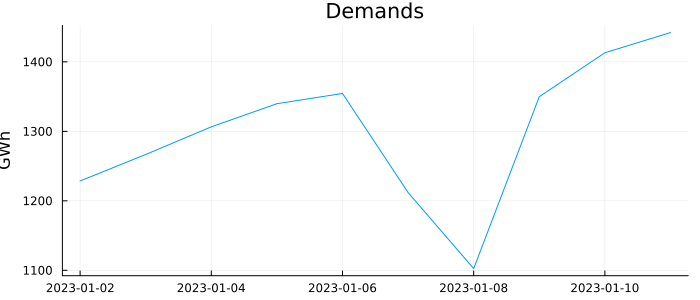

In [13]:
rhsterm = getrhsterms(modelobjects[Id("Balance", "PowerBalance_GER")])[1]

x = []
y = []

for t in 1:getnumperiods(power_horizon)
    querystart = getstarttime(power_horizon, t, prob_time)
    querydelta = gettimedelta(power_horizon, t)
    push!(x, getdatatime(querystart))
    push!(y, getparamvalue(rhsterm, querystart, querydelta))
end
plot(x, y, legend=false, size=(700,300), ylabel = "GWh", title = "Demands")

This plot shows that the first day will have 1228.595 power demand that needs to be generated.

In [14]:
y[1]

1228.595

This also the demand what was put into the power balance of GER for the first period, and that the production units needed to produce.

In [15]:
prob.model[:BalancePowerBalance_GER][1]

BalancePowerBalance_GER[1] : -FlowGenBioGER[1] - FlowGenCoalGER[1] - FlowGenNucGER[1] == -1228.595

### Production unit: GenCoalGER

We take a more detailed look at the modelobject of the power generation unit GenCoalGER. It is a struct of type Flow which represents a variable for each period in an Horizon. The Flow type has eight fields:
- id, which contains the name of the Flow and its type
- arrows connect the Flow to Balances. Here it means that the GenCoalGER variable will contribute as a supply to BalancePowerBalance_GER.
- horizon for a Flow is the Balance Horizon with finest time resolution pointed to by its Arrows. This way, the Flow variable can appear in all connected Balances regardless of their Horizon.
- ub/lb, upper and lower capacities for production of the variable 
- costs is a objective function cost parameter for the variable. GenCoalGER will contribute with a cost to the objective function.
- metadata, can store extra information about the model object

We print the fields and the contents of the GenCoalGER modelobject:

In [16]:
display(fieldnames(typeof(modelobjects[Id("Flow", "GenCoalGER")])))

(:id, :horizon, :ub, :lb, :costs, :sumcost, :arrows, :metadata)

In [17]:
display(getid(modelobjects[Id("Flow", "GenCoalGER")]))
display([getid(arrow) for arrow in getarrows(modelobjects[Id("Flow", "GenCoalGER")])])
display(gethorizon(modelobjects[Id("Flow", "GenCoalGER")]))
display(getub(modelobjects[Id("Flow", "GenCoalGER")]))
display(getlb(modelobjects[Id("Flow", "GenCoalGER")]))
display(getcost(modelobjects[Id("Flow", "GenCoalGER")]))

Id("Flow", "GenCoalGER")

1-element Vector{Id}:
 Id("Arrow", "PowerSupplyCoalGER")

SequentialHorizon(SequentialPeriods([(10, Millisecond(86400000))]), nothing)

PositiveCapacity(Id("Capacity", "CapCoalGER"), MWToGWhSeriesParam{ConstantTimeVector, ConstantTimeVector}(ConstantTimeVector(150000.0), ConstantTimeVector(1.0)), true)

LowerZeroCapacity()

SimpleSumCost(Cost[CostTerm(Id("Cost", "MCCoalGER"), FossilMCParam{ConstantTimeVector, ConstantTimeVector, ConstantTimeVector, ConstantTimeVector, ConstantTimeVector, ConstantTimeVector, ConstantTimeVector}(ConstantTimeVector(30000.0), ConstantTimeVector(1.0), ConstantTimeVector(0.36), ConstantTimeVector(50000.0), ConstantTimeVector(1.0), ConstantTimeVector(0.4), ConstantTimeVector(4000.0)), true)])

We look at the dataelements used to build GenCoalGer

In [18]:
data["elements_coal"]

13-element Vector{DataElement}:
 DataElement("Flow", "BaseFlow", "GenCoalGER", Dict{Any, Any}())
 DataElement("Arrow", "BaseArrow", "PowerSupplyCoalGER", Dict{Any, Any}("Balance" => "PowerBalance_GER", "Flow" => "GenCoalGER", "Conversion" => 1.0, "Direction" => "In"))
 DataElement("Capacity", "PositiveCapacity", "CapCoalGER", Dict{Any, Any}("Param" => "CapCoalGER", "WhichInstance" => "GenCoalGER", "WhichConcept" => "Flow", "Bound" => "Upper"))
 DataElement("Param", "MWToGWhSeriesParam", "CapCoalGER", Dict{Any, Any}("Level" => 150000.0, "Profile" => 1.0))
 DataElement("Cost", "CostTerm", "MCCoalGER", Dict{Any, Any}("Param" => "MCCoalGER", "WhichInstance" => "GenCoalGER", "WhichConcept" => "Flow", "Direction" => "In"))
 DataElement("Param", "FossilMCParam", "MCCoalGER", Dict("CO2Profile" => "CO2Profile", "CO2Level" => "CO2Level", "FuelProfile" => "ProfileCoal", "FuelLevel" => "LevelCoal", "CO2Factor" => "CO2FactorCoal", "Efficiency" => "EfficiencyCoal", "VOC" => "VOCCoal"))
 DataElement(

The Flow element creates the modelobject, the arrow data element connects this flow object to the power balance and CapCoalGer is the capacity for power generation. The other dataelements are related to the marginal cost.

```julia
DataElement("Flow", "BaseFlow", "GenCoalGER", 
    Dict())
DataElement("Arrow", "BaseArrow", "PowerSupplyCoalGER", 
    Dict("Balance" => "PowerBalance_GER",
         "Flow" => "GenCoalGER", 
         "Conversion" => 1.0, 
         "Direction" => "In"))
DataElement("Capacity", "PositiveCapacity", "CapCoalGER", 
    Dict("Param" => "CapCoalGER", 
         "WhichInstance" => "GenCoalGER", 
         "WhichConcept" => "Flow", 
         "Bound" => "Upper"))
DataElement("Param", "MWToGWhSeriesParam", "CapCoalGER", 
    Dict("Level" => 1.5e10, 
         "Profile" => 1.0))
```

#### Cost

Each power generation will have a cost, which should be minimized in the optimizations. These can be single values or sums of multiple values, they can be constant or vary over time. Some examples are seen below.

GenNucGER and GenBioGER have a constant cost of 5000 and 50000 per GWh of produced power.

In [19]:
modelobjects[Id("Flow", "GenNucGER")].sumcost

SimpleSumCost(Cost[CostTerm(Id("Cost", "MCNucGER"), ConstantParam{Float64}(5000.0), true)])

GenCoalGER is more complex and have multiple cost values

In [20]:
sumcost_coal = modelobjects[Id("Flow", "GenCoalGER")].sumcost
print(json(sumcost_coal,4))
sumcost_coal

{
    "terms": [
        {
            "id": {
                "conceptname": "Cost",
                "instancename": "MCCoalGER"
            },
            "param": {
                "fuellevel": {
                    "value": 30000.0
                },
                "fuelprofile": {
                    "value": 1.0
                },
                "co2factor": {
                    "value": 0.36
                },
                "co2level": {
                    "value": 50000.0
                },
                "co2profile": {
                    "value": 1.0
                },
                "efficiency": {
                    "value": 0.4
                },
                "voc": {
                    "value": 4000.0
                }
            },
            "isingoing": true
        }
    ]
}


SimpleSumCost(Cost[CostTerm(Id("Cost", "MCCoalGER"), FossilMCParam{ConstantTimeVector, ConstantTimeVector, ConstantTimeVector, ConstantTimeVector, ConstantTimeVector, ConstantTimeVector, ConstantTimeVector}(ConstantTimeVector(30000.0), ConstantTimeVector(1.0), ConstantTimeVector(0.36), ConstantTimeVector(50000.0), ConstantTimeVector(1.0), ConstantTimeVector(0.4), ConstantTimeVector(4000.0)), true)])

In this case the timevectors are all constant (ConstantTimeVector). For non-constant the scenariotime would be used to fetch the profile values and datatime would be used for the other values. The formula for FossilMCParam cost is 

 $$\frac{(fuellevel * fuelprofile + co2factor * co2level * co2profile)}{efficiency} + voc $$    

In [21]:
(30000.0 * 1.0 +  0.36 * 50000.0 * 1.0) / 0.4 + 4000.0

124000.0

This value will then be the coefficient intfront of the coal generation variable.
```julia
        124000 * FlowGenCoalGER[1]
```

In [22]:
querydelta = gettimedelta(power_horizon, 1)
querystart = getstarttime(power_horizon, 1, prob_time)
rhsterm = modelobjects[Id("Flow", "GenCoalGER")].sumcost
getparamvalue(rhsterm, querystart, querydelta)

124000.0

#### Upper bound capacity

Another important parameter is the capacity, power plants have an upper limit on how much power they can generate. This is a constant value in this example and will become another set of constraints for the optimization.

For example GenBioGER has an upper limit 5000 MW.

```julia
PositiveCapacity(Id("Capacity", "CapBioGER"), MWToGWhSeriesParam{ConstantTimeVector, ConstantTimeVector}(ConstantTimeVector(5000.0), ConstantTimeVector(1.0)), true)
```

GenNucGER has the same limit
```julia
PositiveCapacity(Id("Capacity", "CapNucGER"), MWToGWhSeriesParam{ConstantTimeVector, ConstantTimeVector}(ConstantTimeVector(5000.0), ConstantTimeVector(1.0)), true)
```

lower limit is 0

In [23]:
println(modelobjects[Id("Flow", "GenNucGER")].ub)
println(modelobjects[Id("Flow", "GenBioGER")].ub)
println(modelobjects[Id("Flow", "GenCoalGER")].ub)
println(modelobjects[Id("Flow", "GenNucGER")].lb)
println(modelobjects[Id("Flow", "GenBioGER")].lb)
println(modelobjects[Id("Flow", "GenCoalGER")].lb)

PositiveCapacity(

Id(

"Capacity", "CapNucGER"), MWToGWhSeriesParam{ConstantTimeVector, ConstantTimeVector}(ConstantTimeVector(5000.0), ConstantTimeVector(1.0)), true)
PositiveCapacity(Id("Capacity"

, "CapBioGER"), MWToGWhSeriesParam{ConstantTimeVector, ConstantTimeVector}(ConstantTimeVector(5000.0), ConstantTimeVector(1.0)), true)
PositiveCapacity(Id("Capacity", "CapCoalGER"), MWToGWhSeriesParam{ConstantTimeVector, ConstantTimeVector}(ConstantTimeVector(150000.0), ConstantTimeVector(1.0)), true)


LowerZeroCapacity()
LowerZeroCapacity()
LowerZeroCapacity()


To get the actual value used in the optimization:

In [24]:
querydelta = gettimedelta(power_horizon, 1)
getparamvalue(modelobjects[Id("Flow", "GenNucGER")].ub, prob_time, querydelta)

120.0

The final calculation to get to 120 GWh, which is the max value both nuclear and bio can generate, is this formula.
$$ \frac{5000*1 * 24}{1000} $$

This is because of the MWToGWhSeriesParam datatype, which interpret the 5000 value as MW and will use the duration of a period to aggregate it (24 hours). As usual the level and profile are multiplied together.

```julia
level: ConstantTimeVector(5000.0)
profile: ConstantTimeVector(1.0)
```